In [7]:
import tensorflow as tf
from ray.rllib.offline.json_reader import JsonReader
import numpy as np
import numpy_indexed as npi
import pandas as pd
from IPython.display import display
import graphviz
import numpy as np
import ipywidgets as widgets

In [ ]:
def convert_ts_np_to_df(np_true_state):
    column_dict = {}
    for node in range(13):
        column_dict[f"{node}_unknown"] = np_true_state[:,node*6+0]
        column_dict[f"{node}_known"] = np_true_state[:,node*6+1]
        column_dict[f"{node}_scanned"] = np_true_state[:,node*6+2]
        column_dict[f"{node}_none"] = np_true_state[:,node*6+3]
        column_dict[f"{node}_user"] = np_true_state[:,node*6+4]
        column_dict[f"{node}_privileged"] = np_true_state[:,node*6+5]
    
    dataset = pd.DataFrame(column_dict)
    return dataset

In [ ]:
input_reader = JsonReader("logs/APPO/TrueStates_100_4000")


dfs = []
for e in range(4000):
    print(f"loading {e}")
    data = input_reader.next()
#     print(data["pre_action_true_states"].shape)
#     print(data["obs"].shape)
#     print(data["pre_action_true_states"].shape)
    assert(data["obs"].shape[0] == data["pre_action_true_states"].shape[0])
    dfs.append(convert_to_dataframe(data["pre_action_true_states"]).drop_duplicates())
    dfs.append(convert_to_dataframe(data["blue_action_true_states"]).drop_duplicates())
    dfs.append(convert_to_dataframe(data["red_action_true_states"]).drop_duplicates())

print(f"concatenating")
dataset = pd.concat(dfs, ignore_index=True)

print(dataset.tail())

print(f"number of rows = {dataset.shape[0]}")
print("dropping duplicates...")

dataset = dataset.drop_duplicates()
print(f"number of rows = {dataset.shape[0]}")

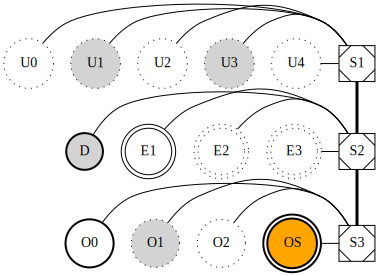

In [8]:
class TrueStateTree:
    def __init__(self, true_state_numpy):
        g = graphviz.Digraph(format='png')
        g.attr(rankdir='TB')
        
        self.subnet_indices = [[8,9,10,11,12],[0,1,2,3],[4,5,6,7]]
        self.server_indices = [1,2,3,7]
        for i,indices in enumerate(self.subnet_indices):
            with g.subgraph() as s:
                sname = f"S{i+1}"
                s.attr(rank="same")
                s.node(sname, shape='Msquare')
                for i in indices:
                    node = self.get_node(s, sname,i,true_state_numpy)
        
        g.edge("S1","S2",arrowhead="none", penwidth="3")
        g.edge("S2","S3",arrowhead="none", penwidth="3")
        self.g = g
        
    def display(self):
        display(self.g)
        
    def get_node(self, subgraph, subnet_name, i, np_arr):
        name = self.index_to_name(i)
        subnet = subnet_name #self.index_to_subnet(i)
        known = bool(np_arr[i,0,1])
        scanned = bool(np_arr[i,0,2])
        user = bool(np_arr[i,1,1])
        priv = bool(np_arr[i,1,2])
        style = "dotted,filled"
        if known:
            style = "solid,filled"
        if scanned:
            style = "bold,filled"
        
        colour = "white"
        if user:
            colour = "lightgray"
        if priv:
            colour = "orange"
        
        shape = "circle"if i not in self.server_indices else "doublecircle"
        
#         with subgraph:
        node = subgraph.node(name, shape=shape, fillcolor=colour, style=style)
        subgraph.edge(name,subnet,arrowhead="none")
        return node
        
    def index_to_name(self, index):
        if index==0:
            return "D"
        if index <4:
            return f"E{index}"
        if index <7:
            return f"O{index-4}"
        if index ==7:
            return "OS"
        else:
            return f"U{index-8}"


true_state = np.array([[[0,0,1],[0,1,0]],
                       [[1,1,0],[0,0,0]],
                       [[1,0,0],[0,0,0]],
                       [[1,0,0],[0,0,0]],
                       [[1,0,1],[0,0,0]],
                       [[1,0,0],[0,1,0]],
                       [[1,0,0],[0,0,0]],
                       [[0,0,1],[0,0,1]],
                       [[1,0,0],[0,0,0]],
                       [[1,0,0],[0,1,0]],
                       [[1,0,0],[0,0,0]],
                       [[1,0,0],[0,1,0]],
                       [[1,0,0],[0,0,0]]])     
tree = TrueStateTree(true_state)
tree.display()

In [115]:
wi1 = widgets.Image(value=tree.g.pipe(), format='png', width=400)
wi2 = widgets.Image(value=tree.g.pipe(), format='png', width=400)
sidebyside = widgets.HBox([wi1, wi2])
display(sidebyside)

In [20]:
def display_tree_pairs(tree_pairs):
    length = len(tree_pairs)
    print(length)
    index = 0

    prev_button = widgets.Button(description="<<")
    next_button = widgets.Button(description=">>")
    int_slider = widgets.IntSlider(name='Index', min=0, max=length-1, step=1, value=index)
    # output = widgets.Output()
    sidebyside_controls = widgets.HBox([prev_button, next_button, int_slider])
    
    wi1 = widgets.Image(value = tree_pairs[index][0].g.pipe(), format='png', width=400)
    wi2 = widgets.Image(value = tree_pairs[index][1].g.pipe(), format='png', width=400)
    sidebyside_images = widgets.HBox([wi1, wi2])

    def update_images(index):
        nonlocal wi1, wi2, tree_pairs, sidebyside_controls, sidebyside_images
        wi1.value = tree_pairs[index][0].g.pipe()
        wi2.value = tree_pairs[index][1].g.pipe()
#         display(sidebyside_controls, sidebyside_images)
    
    def on_button_clicked(b):
        nonlocal index, length
        if b ==prev_button:
            if index >0:
                index -= 1
                update_images(index)
        else:
            if index < length-1:
                index += 1
                update_images(index)
        int_slider.value=index
    #     with output:


    def on_value_change(change):
        nonlocal index
        if index != change.new:
            index = change.new
            update_images(index)

    int_slider.observe(on_value_change, names='value')

    prev_button.on_click(on_button_clicked)
    next_button.on_click(on_button_clicked)
    
#     update_images(index)

    display(sidebyside_controls, sidebyside_images)

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:

true_state = np.array([[[0,0,1],[0,1,0]],
                       [[1,1,0],[0,0,0]],
                       [[1,0,0],[0,0,0]],
                       [[1,0,0],[0,0,0]],
                       [[1,0,1],[0,0,0]],
                       [[1,0,0],[0,1,0]],
                       [[1,0,0],[0,0,0]],
                       [[0,0,1],[0,0,1]],
                       [[1,0,0],[0,0,0]],
                       [[1,0,0],[0,1,0]],
                       [[1,0,0],[0,0,0]],
                       [[1,0,0],[0,1,0]],
                       [[1,0,0],[0,0,0]]])     
tree1 = TrueStateTree(true_state)

true_state = np.array([[[0,0,0],[0,0,0]],
                       [[1,0,0],[1,0,0]],
                       [[1,0,0],[1,0,0]],
                       [[1,0,0],[0,1,0]],
                       [[1,0,1],[0,0,0]],
                       [[1,0,0],[1,0,0]],
                       [[1,0,0],[0,0,0]],
                       [[0,0,1],[0,1,0]],
                       [[1,0,0],[0,0,0]],
                       [[1,0,0],[0,1,0]],
                       [[1,0,0],[0,0,0]],
                       [[0,1,0],[0,1,0]],
                       [[1,0,0],[0,0,0]]])     
tree2 = TrueStateTree(true_state)

tree_pairs = [[tree1,tree1],[tree2,tree2]]
display_tree_pairs(tree_pairs)

2


/usr/local/lib/python3.8/dist-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(IntSlider).__init__(name='Index').
object.__init__() takes exactly one argument (the instance to initialize)
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)
